In [1]:
import matplotlib.image as mp_image
import matplotlib.pyplot as plt
import subprocess
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from functools import partial
sess = tf.Session()

In [2]:
def extract_filename(full_name, filename_extension):
    return full_name.split(sep="."+filename_extension)[0].split(sep='/')[-1]

extract_png_filename = partial(extract_filename, filename_extension='png')

## 讀取訓練資料到陣列

In [3]:
# ground truth
df_UNBC_pain_score = pd.read_csv('./UNBC_pain_score_table.csv') # 讀取疼痛分數資料
df_UNBC_pain_score.sort_values(by=['PSPI'], ascending=False, inplace=True) # 高分排前面
df_UNBC_pain_score.reset_index(drop=True, inplace=True) # 更新 index

In [4]:
# feed training data

# 建構檔案路徑
# croped_face_folder = '../datalake/crop_face_from_UNBC_pain/'
file_ext = '.png'
# 讀取目錄底下所有檔案絕對路徑
paths_croped_face_img = subprocess.getoutput('find ../datalake/crop_face_from_UNBC_pain/ -type f -name "*.png"').split('\n')
print("count = {}".format(+len(paths_croped_face_img)))
# paths_croped_face_img

count = 46376


In [5]:
# 只使用有被偵測到臉的
df_croped_face_img = pd.DataFrame(
                        data = {'full_name':paths_croped_face_img, 
                                'file_name':[i for i in map(extract_png_filename, paths_croped_face_img)]})

In [6]:
# 合併檔案路徑表和分數表，之後只用這張表，清空不必要變數
df_croped_face_img = df_croped_face_img.merge(right=df_UNBC_pain_score, on='file_name', how='inner')
paths_croped_face_img = []
df_UNBC_pain_score = []
print(df_croped_face_img.index.size)

46376


In [7]:
# 把臉部 ROI 轉化成可以直接輸入 nn 的 vector
def rect_img_to_input_vector(raw_img):
    import skimage
    gray_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY) #轉灰
#     gray_img = cv2.equalizeHist(gray_img) #亮度正規化
    norm_size_img = cv2.resize(gray_img,(128, 128)) #統一尺寸
    max_pooling_img = skimage.measure.block_reduce(norm_size_img, (4,4), np.max) #最大池化
    reshape_img = np.reshape(max_pooling_img, [-1]) #拉平
    return reshape_img

In [8]:
# 讀取影像函式
def read_dataset(list_data_path):
    import skimage.measure
    dataset = []
    read_fail_set = []
    print("read img {:5d}, {}".format(len(dataset), subprocess.getoutput('date')))
    #-------------------------------------------------------------------
    for img_full_name in list_data_path:
        try:
            raw_img = cv2.imread(img_full_name)
        except:
            read_fail_set.append(img_full_name)
            print(img_full_name, len(read_fail_set))

        dataset.append(rect_img_to_input_vector(raw_img)) #push in list

        if(0 == len(dataset)%5000):
            print("read img {:5d}, {}".format(len(dataset), subprocess.getoutput('date')))
    #-------------------------------------------------------------------
    print("read img {:5d}, {}".format(len(dataset), subprocess.getoutput('date')))
    return dataset

## 分類用資料編碼

In [9]:
# 產生 one-hot labels
PSPI_one_hot = tf.Session().run(
                    tf.one_hot(indices=df_croped_face_img['PSPI'].values, # 被 one-hot data
                    depth = len(df_croped_face_img['PSPI'].unique()), # 取集合大小
                    dtype = tf.int32))
df_croped_face_img['PSPI_one_hot'] = pd.Series(PSPI_one_hot.tolist())

In [10]:
len(df_croped_face_img['PSPI_one_hot'][0])


16

## 分割預備

In [11]:
# shuffle
df_croped_face_img = df_croped_face_img.reindex(index = np.random.permutation(df_croped_face_img.index))

In [12]:
# 只以 PSPI 排序
df_croped_face_img.sort_values(by=['PSPI'], ascending=False, inplace=True)

In [13]:
# 重新給 index，不留原本的 index
df_croped_face_img.reset_index(inplace=True, drop=True)

## 分割 [ 訓練集 , 測試集 ]

In [14]:
# 雙數抽樣(訓練集)
df_croped_face_img_training = df_croped_face_img.iloc[[i for i in df_croped_face_img.index if i&1==0 ],:]

# 單數抽樣(測試集)
df_croped_face_img_validation = df_croped_face_img.iloc[[i for i in df_croped_face_img.index if i&1==1 ],:]

## 讀取資料集影像內容

In [15]:
training_img_raw_dataset = read_dataset(df_croped_face_img_training['full_name'])
validation_img_raw_dataset = read_dataset(df_croped_face_img_validation['full_name'])

read img     0, Fri Sep  8 21:19:54 CST 2017
read img  5000, Fri Sep  8 21:20:07 CST 2017
read img 10000, Fri Sep  8 21:20:20 CST 2017
read img 15000, Fri Sep  8 21:20:34 CST 2017
read img 20000, Fri Sep  8 21:20:47 CST 2017
read img 23188, Fri Sep  8 21:20:56 CST 2017
read img     0, Fri Sep  8 21:20:56 CST 2017
read img  5000, Fri Sep  8 21:21:08 CST 2017
read img 10000, Fri Sep  8 21:21:22 CST 2017
read img 15000, Fri Sep  8 21:21:35 CST 2017
read img 20000, Fri Sep  8 21:21:48 CST 2017
read img 23188, Fri Sep  8 21:21:57 CST 2017


In [16]:
# 對資料集正規化
## 正規化的單位並不是一張影像，而是一個位置，所以是對每一張影像的同一個位置的像素正規化
from sklearn import preprocessing
training_img_dataset = preprocessing.minmax_scale(training_img_raw_dataset,(-0.9, 0.9))
validation_img_dataset = preprocessing.minmax_scale(validation_img_raw_dataset,(-0.9, 0.9))
print("{}".format(subprocess.getoutput('date')))

Fri Sep  8 21:21:58 CST 2017


## Neural Network construct

In [17]:
# 建構神經網路

# 單層建構函式
def make_layer(inputs, in_size, out_size, activation_function=None):
    Weights = tf.Variable(tf.random_normal([in_size, out_size]))
    biases = tf.Variable(tf.zeros([1, out_size]) + 0.1)
    Wx_plus_b = tf.add(tf.matmul(inputs, Weights), biases)
    if activation_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activation_function(Wx_plus_b)
    return outputs

in_size = 32*32
out_size = len(df_croped_face_img['PSPI'].unique())

# 定義輸出入變數
xs = tf.placeholder(tf.float32, [None, in_size])
ys = tf.placeholder(tf.float32, [None, out_size])

# 定義多層流程
layer_hidden_1 = make_layer(xs, in_size, 32, activation_function = tf.nn.tanh)
layer_output   = make_layer(layer_hidden_1, 32, out_size) 

In [18]:
# 定義損失函數
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=layer_output, labels=ys))

In [19]:
# 定義學習方法
learning_rate = 0.005
momentum = 0.01
train_step = tf.train.MomentumOptimizer(learning_rate, momentum).minimize(loss)

In [92]:
# 變數初始化
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Training

In [93]:
# 模型訓練前的整體誤差
cost = sess.run(loss, feed_dict = {
                                    xs: training_img_dataset,
                                    ys: df_croped_face_img_training['PSPI_one_hot'].tolist() })
print("epoch = None, cost = {}, {}".format(cost , subprocess.getoutput('date')))

# 訓練
for epoch in range(200):
    train_squence = [i for i in range(len(training_img_dataset))] #產生線性的資料流水號序列
    np.random.shuffle(train_squence)
    
    # 這一輪訓練
    for i in train_squence:
        _ = sess.run([train_step], feed_dict = {
                                            xs: [training_img_dataset[i]],
                                            ys: [df_croped_face_img_training['PSPI_one_hot'].iloc[i]]})
    
    # 這一輪訓練後的整體誤差
    cost = sess.run(loss, feed_dict = {
                                    xs: training_img_dataset,
                                    ys: df_croped_face_img_training['PSPI_one_hot'].tolist()})
    print("epoch = {}, cost = {}, {}".format(epoch, cost , subprocess.getoutput('date')))

epoch = None, cost = 12.335647583007812, Fri Sep  8 21:50:15 CST 2017
epoch = 0, cost = 0.6528972387313843, Fri Sep  8 21:50:28 CST 2017
epoch = 1, cost = 0.5503795742988586, Fri Sep  8 21:50:42 CST 2017
epoch = 2, cost = 0.5048807859420776, Fri Sep  8 21:50:55 CST 2017
epoch = 3, cost = 0.4634314775466919, Fri Sep  8 21:51:09 CST 2017
epoch = 4, cost = 0.431471586227417, Fri Sep  8 21:51:23 CST 2017
epoch = 5, cost = 0.41231995820999146, Fri Sep  8 21:51:36 CST 2017
epoch = 6, cost = 0.39371389150619507, Fri Sep  8 21:51:50 CST 2017
epoch = 7, cost = 0.3744477927684784, Fri Sep  8 21:52:03 CST 2017
epoch = 8, cost = 0.3647775948047638, Fri Sep  8 21:52:17 CST 2017
epoch = 9, cost = 0.35833367705345154, Fri Sep  8 21:52:31 CST 2017
epoch = 10, cost = 0.34131482243537903, Fri Sep  8 21:52:44 CST 2017
epoch = 11, cost = 0.3335024416446686, Fri Sep  8 21:52:58 CST 2017
epoch = 12, cost = 0.3211800754070282, Fri Sep  8 21:53:12 CST 2017
epoch = 13, cost = 0.3111186623573303, Fri Sep  8 21:

epoch = 119, cost = 0.10750669240951538, Fri Sep  8 22:17:34 CST 2017
epoch = 120, cost = 0.11204637587070465, Fri Sep  8 22:17:48 CST 2017
epoch = 121, cost = 0.12184291332960129, Fri Sep  8 22:18:01 CST 2017
epoch = 122, cost = 0.1036955937743187, Fri Sep  8 22:18:15 CST 2017
epoch = 123, cost = 0.10526107251644135, Fri Sep  8 22:18:29 CST 2017
epoch = 124, cost = 0.10638885945081711, Fri Sep  8 22:18:42 CST 2017
epoch = 125, cost = 0.10269225388765335, Fri Sep  8 22:18:56 CST 2017
epoch = 126, cost = 0.10691949725151062, Fri Sep  8 22:19:10 CST 2017
epoch = 127, cost = 0.10053576529026031, Fri Sep  8 22:19:23 CST 2017
epoch = 128, cost = 0.10380540788173676, Fri Sep  8 22:19:37 CST 2017
epoch = 129, cost = 0.10408466309309006, Fri Sep  8 22:19:51 CST 2017
epoch = 130, cost = 0.10010211914777756, Fri Sep  8 22:20:04 CST 2017
epoch = 131, cost = 0.10031824558973312, Fri Sep  8 22:20:18 CST 2017
epoch = 132, cost = 0.10223646461963654, Fri Sep  8 22:20:31 CST 2017
epoch = 133, cost = 0

KeyboardInterrupt: 

# Validation

/home/lky/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by the normalize function.
  warnings.warn(msg, _DataConversionWarning)


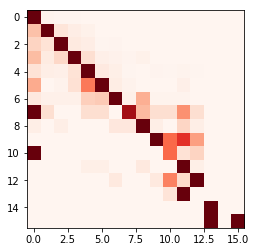

In [116]:
# confusion_matrix
inference_class = sess.run(tf.arg_max(
                                sess.run(layer_output, feed_dict={xs:validation_img_dataset}), dimension=1))
# 不吃 one-hot labels，只吃 1D-arry
confusion_matrix = sess.run(
        tf.confusion_matrix(df_croped_face_img_validation['PSPI'].tolist(),
                            inference_class,
                            num_classes = len(df_croped_face_img_validation['PSPI'].unique())))
from sklearn.preprocessing import normalize
plt.imshow(normalize(confusion_matrix, norm='max'), cmap=plt.cm.Reds)
plt.show()

In [131]:
# 計算實驗結果
from sklearn.metrics import mean_squared_error
predict_result = inference_class
ground_truth = df_croped_face_img_validation['PSPI'].values
print("PCCs = {}".format(np.corrcoef(x=ground_truth, y=predict_result)).replace('\n','\n'+' '*7))
print("MSE  = {}".format(mean_squared_error(ground_truth, predict_result)))

PCCs = [[ 1.          0.81930881]
        [ 0.81930881  1.        ]]
MSE  = 0.6400293255131965


In [132]:
saver = tf.train.Saver()
saver_path = saver.save(sess, "trained_model/train_net_by_pain_face_classification.ckpt")
print(saver_path)

trained_model/train_net_by_pain_face_classification.ckpt
